# All required imports and setting up constants

In [27]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
SEED_CONSTANT= 42
np.random.seed(SEED_CONSTANT)
tf.random.set_seed(SEED_CONSTANT)

DATASET_DIR = 'hmdb51'
#SELECTED_ACTIONS = ['clap', 'climb_stairs', 'drink', 'eat', 'fall_floor', 'jump', 'run', 'shake_hands', 'sit', 'stand', 'walk', 'wave']
SELECTED_ACTIONS = ['climb_stairs', 'jump', 'run', 'sit', 'stand', 'walk', 'wave']

VIDEO_WIDTH= 75 # Min width is 300
VIDEO_HEIGHT= 60 # All video have same height of 240
MAX_FRAMES= 30 # Maximum of 30 frames from each video

# Visualise the data and Categories available

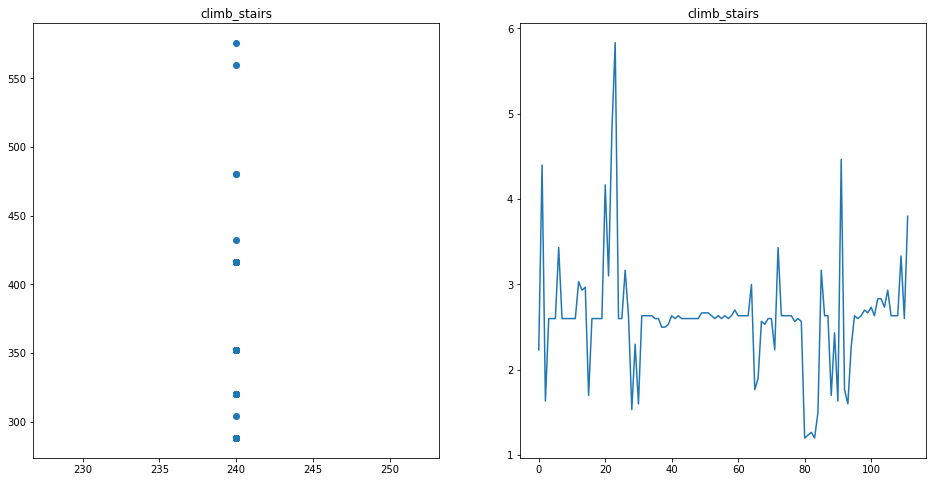

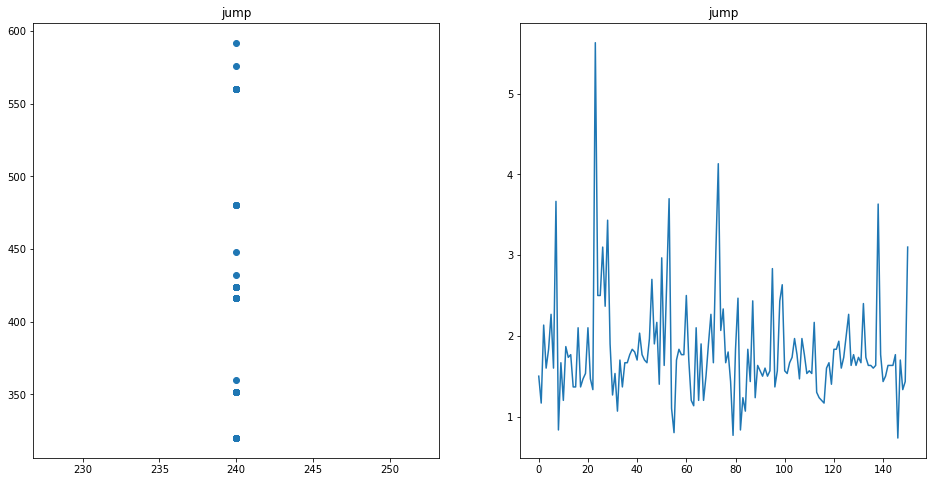

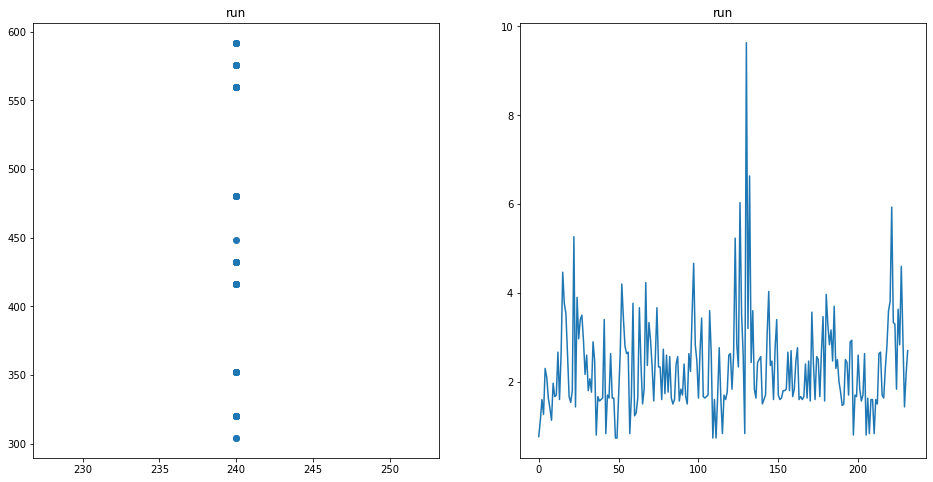

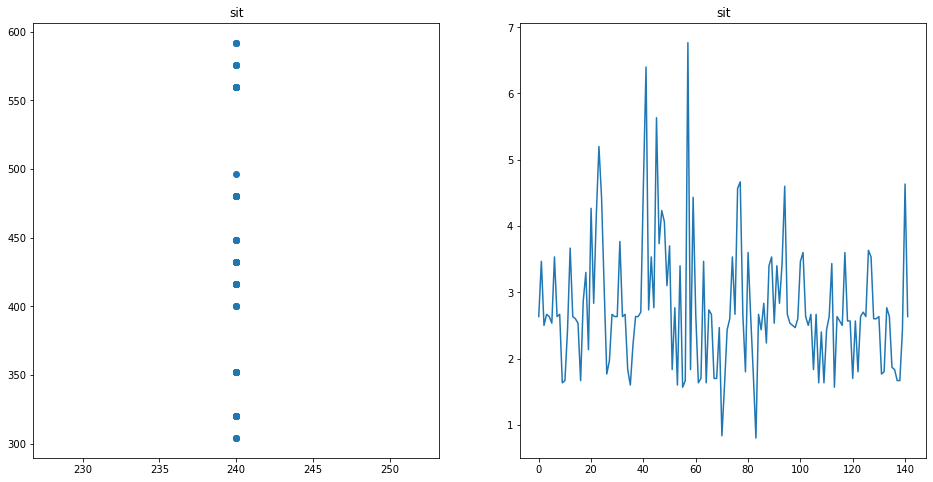

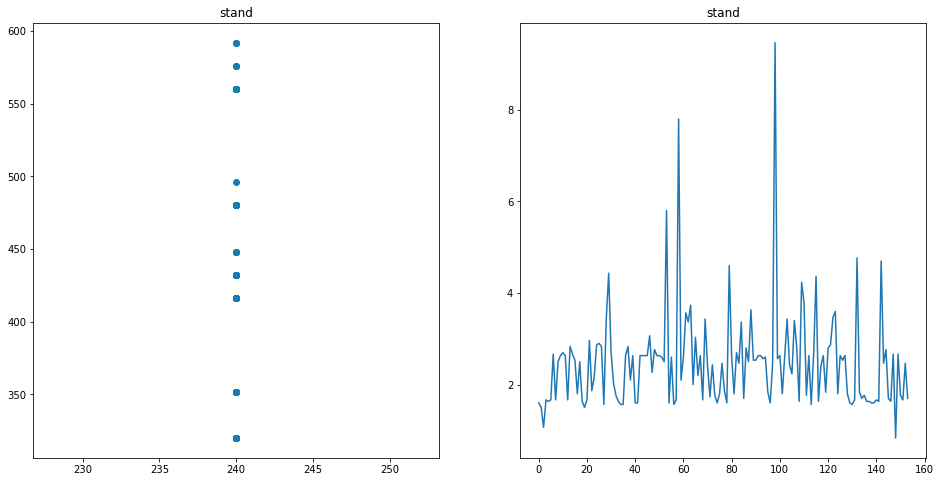

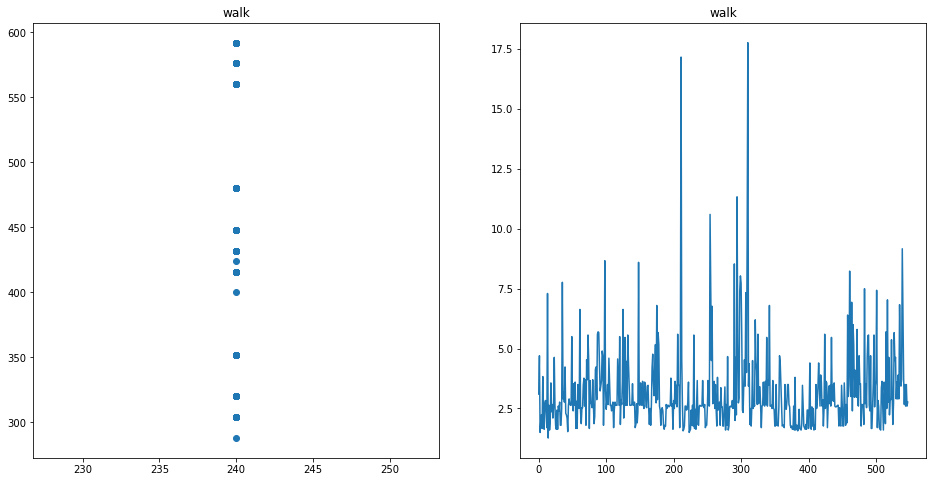

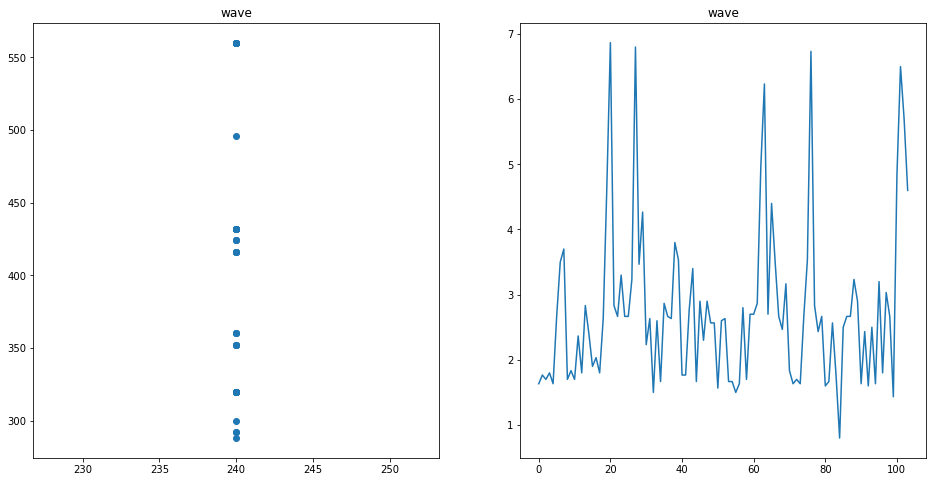

In [11]:
#plt.figure(figsize = (50, 50))
#class_names = os.listdir(DATASET_DIR)
#class_names = os.listdir('UCF-101')

for i, currentAction in enumerate(SELECTED_ACTIONS, 1):
    videos = os.listdir(f'{DATASET_DIR}/{currentAction}/{currentAction}')
    #selected_video = random.choice(videos)
    
    videoWidths= []
    videoHeights= []
    videoDurations= []
    # videoFPS= [] all videos are 30 FPS
    for vid in videos:
        cap = cv2.VideoCapture(f'{DATASET_DIR}/{currentAction}/{currentAction}/{vid}')
        videoWidths.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        videoHeights.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        videoDurations.append(cap.get(cv2.CAP_PROP_FRAME_COUNT)/cap.get(cv2.CAP_PROP_FPS))
        # videoFPS.append(cap.get(cv2.CAP_PROP_FPS))
        cap.release()
    
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.scatter(videoHeights, videoWidths)
    plt.title(currentAction)
    plt.subplot(122)
    plt.plot(videoDurations)
    plt.title(currentAction)

    # plt.plot(videoFPS)
    #rgb_first_frame = cv2.cvtColor(first_frame, cv2.COLOR_BGR2RGB)
    
    #plt.subplot(11, 5, i)
    #plt.title(current_class, fontdict={'fontsize': 24})
    #plt.imshow(rgb_first_frame)
    #plt.axis('off')

# Pre-process the video files

In [12]:
def frameExtraction(videoPath):
    frames= []
    cap= cv2.VideoCapture(videoPath)

    frameCount= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frameSkipInterval= max(int(frameCount/MAX_FRAMES), 1)

    for count in range(MAX_FRAMES):
        cap.set(cv2.CAP_PROP_POS_FRAMES, count*frameSkipInterval)
        success, frame = cap.read()
        
        if not success:
            break

        resizedFrame= cv2.resize(frame, (VIDEO_HEIGHT, VIDEO_WIDTH))
        # To normalize the RGB values of each pixel between 0-1
        normalizedFrame= resizedFrame/255
        frames.append(normalizedFrame)

    cap.release()
    return frames

In [13]:
def createDataset():
    features= []
    labels= []

    for action in SELECTED_ACTIONS:
        print(f'Extracting data of action: {action}')
        videoDir= os.listdir(os.path.join(DATASET_DIR, action, action))

        for video in videoDir:
            filePath= os.path.join(DATASET_DIR, action, action, video)
            frames= frameExtraction(filePath)

            if len(frames) == MAX_FRAMES:
                features.append(frames)
                labels.append(action)
    
    features= np.asarray(features)
    labels= np.array(labels)

    return features, labels

In [14]:
features, labels= createDataset()

Extracting data of action: climb_stairs
Extracting data of action: jump
Extracting data of action: run
Extracting data of action: sit
Extracting data of action: stand
Extracting data of action: walk
Extracting data of action: wave


In [29]:
oneHotLabels= OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1, 1))
#print(oneHotLabels)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [30]:
X_train, X_test, y_train, y_test= train_test_split(features, oneHotLabels, test_size=0.25, shuffle=True, random_state=SEED_CONSTANT)

In [34]:
def createConvLSTM2D():

    model = Sequential()

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (MAX_FRAMES, VIDEO_WIDTH, VIDEO_HEIGHT, 3)))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    model.add(Flatten()) 
    
    model.add(Dense(len(SELECTED_ACTIONS), activation = "softmax"))
    

    model.summary()
    return model

In [35]:
convlstm2d_model= createConvLSTM2D()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_12 (ConvLSTM2D) (None, 30, 73, 58, 4)     1024      
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 30, 37, 29, 4)     0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, 30, 37, 29, 4)     0         
_________________________________________________________________
conv_lst_m2d_13 (ConvLSTM2D) (None, 30, 35, 27, 8)     3488      
_________________________________________________________________
max_pooling3d_13 (MaxPooling (None, 30, 18, 14, 8)     0         
_________________________________________________________________
time_distributed_10 (TimeDis (None, 30, 18, 14, 8)     0         
_________________________________________________________________
conv_lst_m2d_14 (ConvLSTM2D) (None, 30, 16, 12, 14)   

In [36]:
earlyStoppingCallback= EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

convlstm2d_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

convlstm2d_model_training= convlstm2d_model.fit(x= X_train, y= y_train, epochs= 30, shuffle= True, validation_split= 0.2, callbacks=[earlyStoppingCallback])

Epoch 1/30
 7/27 [======>.......................] - ETA: 2:37 - loss: 1.8832 - accuracy: 0.2723

KeyboardInterrupt: 